### import packages

In [34]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import re
import string
from copy import copy
import nltk
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [35]:
tagged = pd.read_csv('cleaned_tagged.csv', sep=',')
Relevant = np.array([0]*tagged.size)
Relevant[tagged[tagged.sentiment!=-1].index.tolist()] = 1
tagged['Relevant'] = pd.Series(Relevant, name='Relevant')
tagged = tagged.drop(tagged.columns[0], axis=1).reset_index(drop=True)
tagged.to_csv('relevant_binary_tagged.csv')

### 1) tweets data loaded into Jupyter Notebook as Table object

In [36]:
df = ds.Table.read_table('relevant_binary_tagged.csv', sep=',')
df

Unnamed: 0,user_id,user_name,tweet_time,location,text,sentiment,Relevant
0,802657195661742080,Christine Warren,Wed Sep 12 01:38:14 +0000 2018,Fremont CA,2 american lives were just lost in tennessee potus pleas ...,0,1
1,1039245812230893570,Trumpservative,Wed Sep 12 01:38:16 +0000 2018,Tulsa OK,realfarmacist realdonaldtrump tuckercarlson our great le ...,1,1
2,282084840,Darrel Sheldon #MAGAVETERAN,Wed Sep 12 01:38:18 +0000 2018,None,rightgottweets rev out the trumptrain for bluemilwaukee ...,0,1
3,62315639,Queer Liberal Voting Snowflake,Wed Sep 12 01:38:18 +0000 2018,Big Sandy Texas,tennessee is suffering after shooting takes 2 lives potu ...,0,1
4,823307049266245633,don jones #veteran (K),Wed Sep 12 01:38:19 +0000 2018,United States,sassytjoy bcmsolt fightinirish109 dybarb wolfiev3 kevinh ...,-1,0
5,340428574,DelcoGal,Wed Sep 12 01:38:21 +0000 2018,Pennsylvania,loudobbs redwaverising sidneypowell1 this years midterm ...,1,1
6,1603928228,Julz,Wed Sep 12 01:38:22 +0000 2018,MIAATLPGH,2 lives were just lost in tennessee potus its time to do ...,0,1
7,1865678516,Barbara Kuczinski,Wed Sep 12 01:38:22 +0000 2018,None,mollympengra realjameswoods obama mollympengra oh hon cn ...,1,1
8,59288409,Josh Steed PhD,Wed Sep 12 01:38:25 +0000 2018,Arkansas,jillibean557 msm is repulsive they do nothing but lie an ...,0,1
9,325172419,Mrs. Linz,Wed Sep 12 01:38:25 +0000 2018,BC Canada,jc61384960 loricoutler amymek muslims coming illegally a ...,2,1


### data preprocessing

In [37]:
relevant_tweet = df.where('Relevant', are.equal_to(1))
irrelevant_tweet = df.where('Relevant', are.equal_to(0))

In [38]:
relevant_tweet_cnt = relevant_tweet.num_rows
irrelevant_tweet_cnt = irrelevant_tweet.num_rows

In [39]:
relevant_tweet_cnt, irrelevant_tweet_cnt

(1133, 163)

In [40]:
relevant_training_size = round(relevant_tweet_cnt*0.8)
irrelevant_training_size = round(irrelevant_tweet_cnt*0.8)

In [41]:
relevant_training_size, irrelevant_training_size

(906, 130)

In [42]:
relevant_train_idx = list(range(relevant_training_size))
irrelevant_train_idx = list(range(irrelevant_training_size))
relevant_test_idx = list(range(relevant_tweet_cnt))[int(relevant_training_size):]
irrelevant_test_idx = list(range(irrelevant_tweet_cnt))[irrelevant_training_size:]


relevant_training_text = list(relevant_tweet.take(relevant_train_idx)['text'])
irrelevant_training_text = list(irrelevant_tweet.take(irrelevant_train_idx)['text'])
relevant_training_relevant = list(relevant_tweet.take(relevant_train_idx)['Relevant'])
irrelevant_training_relevant = list(irrelevant_tweet.take(irrelevant_train_idx)['Relevant'])

relevant_testing_text = list(relevant_tweet.take(relevant_test_idx)['text'])
irrelevant_testing_text = list(irrelevant_tweet.take(irrelevant_test_idx)['text'])
relevant_testing_relevant = list(relevant_tweet.take(relevant_test_idx)['Relevant'])
irrelevant_testing_relevant = list(irrelevant_tweet.take(irrelevant_test_idx)['Relevant'])

X_train = relevant_training_text + irrelevant_training_text
y_train = relevant_training_relevant + irrelevant_training_relevant
X_test = relevant_testing_text + irrelevant_testing_text
y_test = relevant_testing_relevant + irrelevant_testing_relevant


### 2)  showing the sizes of your training and testing sets (number of relevant training + irrelevant training, number of relevant testing + irrelevant testing)

In [43]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1036, 260, 1036, 260)

#### Model (Bag of Words + DTree)

In [44]:
vect = CountVectorizer(
     analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000)
# vect = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l1', encoding='latin-1', 
#                         ngram_range=(1,2), stop_words='english')
X_train_vect = vect.fit_transform(X_train).todense()
X_test_vect = vect.transform(X_test)
X_train_vect.shape, X_test_vect.shape

((1036, 3000), (260, 3000))

In [45]:
clf = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = 100,
                            max_depth = 5,
                            min_samples_leaf = 2)
# clf = RandomForestClassifier(random_state=100,
#                              n_estimators=60, 
#                              criterion='entropy', 
#                              n_jobs=4)
# clf = XGBoostClassifier(max_depth=5, n_estimators=5)
# clf = LogisticRegression()
clf.fit(X_train_vect, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [33]:
y_pred = clf.predict(X_test_vect)
np.mean([cross_val_score(clf, X_train_vect, y_train, cv=8)])

0.8745339960944435

### 3)  the confusion matrix of evaluating your Decision Tree-based relevant classifier using TESTING data, and identify false positive and false negative in your evaluation result.

In [46]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  0,  33],
       [  0, 227]])

In [47]:
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
TN = cm[0][0]
print('The False Positive:', FP)
print('The False Negative:', FN)
print('The True Positive:', TP)
print('The True Negative:', TN)

The False Positive: 33
The False Negative: 0
The True Positive: 227
The True Negative: 0


In [53]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=vect.get_feature_names())
graph = Source(dot_data)
graph.render('RelevantClassifier')

'RelevantClassifier.pdf'

### 4) A visualization of your decision tree.

![](tree_depth_5.png)

### 5) A description of a rule based on the tree

- If potus<=0.5:
    - If realdonaldtrump<=0.5:
        - If trump > 0.5:
            - then the tree reaches the leaf, value = $[0, 87]$, indicating that there are 87 tweets are categorized as `Relevant`

### 6) A short summary of your evaluation result using the confusion matrix

[[  0  33]
 [  0 227]]


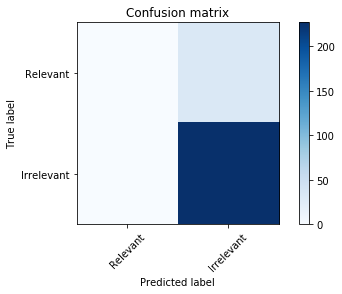

In [58]:
def plot_cm(cm, title='Confusion matrix', cmap=plt.cm.Blues, classes=['Relevant', 'Irrelevant']):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    target_names = classes
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_cm(confusion_matrix(y_test, y_pred))

In [56]:
print("AUC(ROC): " + str(metrics.roc_auc_score(y_test, y_pred)))
print("Precision: " + str(metrics.precision_score(y_test, y_pred)))
print("Recall: " + str(metrics.recall_score(y_test, y_pred)))
print("F1 score: " + str(metrics.f1_score(y_test, y_pred)))

AUC(ROC): 0.5
Precision: 0.8730769230769231
Recall: 1.0
F1 score: 0.9322381930184805


Here we can see from the confusion matrix that the `True Negative`=0, and `False Positive`=33, which means all 33 `Irrelevant` tweets are categorized as `Relevant`. Thus there appears to have a serious problem here: even with the accuracy is decent, it is actually inflated. The reason for that is because the proportion of `Relevant` tweets(__1133/1296__) is way larger than that of `Irrelevant` tweets(__163/1296__), thus

$$accuracy = \frac{TP+TN}{TP+TN+FN+FP} = \frac{227}{260} = 87.3\%$$

In fact, with the task being to filter out the irrelevant tweets, this classifier basically fails the task because of the unbalanced data.

### Possible fixes:
- Resampling
    - Downsampling on the `Relevant` tweets
    - Upsampling on the `Irrelevant` tweets

In [61]:
def classify(X_train_vect, y_train, X_test_vect, y_test, model, vector):
    clf.fit(X_train_vect, y_train)
    y_pred = clf.predict(X_test_vect)
    cross_val_s = np.mean([cross_val_score(model, X_train_vect, y_train, cv=8)])
    print('Cross_val_score: {}'.format(cross_val_s))
    print("AUC(ROC): " + str(metrics.roc_auc_score(y_test, y_pred)))
    print("Precision: " + str(metrics.precision_score(y_test, y_pred)))
    print("Recall: " + str(metrics.recall_score(y_test, y_pred)))
    print("F1 score: " + str(metrics.f1_score(y_test, y_pred)))
    print(metrics.confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(5,5))
    plot_cm(metrics.confusion_matrix(y_test, y_pred))
    plt.show()
    return cross_val_s

### Experiment 1: Downsample the `Relevant` data

In [62]:
def undersample(data, percentage, vector):
    relevant_idx = tagged[tagged.Relevant==1].index
    irrelevant_idx = tagged[tagged.Relevant==0].index
    undersample_relevant_idx = np.array(np.random.choice(relevant_idx,(int(percentage*len(irrelevant_idx))),replace=False))
    undersample_idx= np.concatenate([irrelevant_idx, undersample_relevant_idx])
    undersample_data = tagged.iloc[undersample_idx,:]
    print('There are {} relevant tweets.\n There are {} irrelevant tweets.'.format(len(undersample_data[undersample_data.Relevant==1]), 
                                                                                   len(undersample_data[undersample_data.Relevant==0])))
    X_train, X_test, y_train, y_test = train_test_split(undersample_data.text, undersample_data.Relevant, test_size=0.2, random_state=100)
    X_train_vect = vector.fit_transform(X_train).todense()
    X_test_vect = vector.transform(X_test)
    plt.figure(figsize=(5,5))
    sns.countplot("Relevant",data=undersample_data)
    plt.show()
    return X_train_vect, X_test_vect, y_train, y_test

There are 163 relevant tweets.
 There are 163 irrelevant tweets.


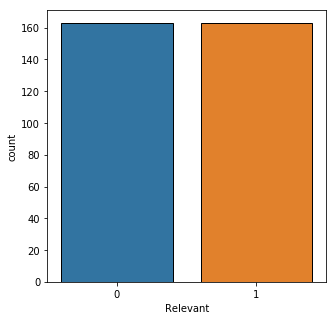

Cross_val_score: 0.8041758308895406
AUC(ROC): 0.8157894736842105
Precision: 1.0
Recall: 0.631578947368421
F1 score: 0.7741935483870968
[[28  0]
 [14 24]]
[[28  0]
 [14 24]]


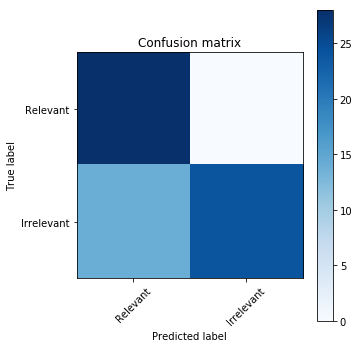

There are 244 relevant tweets.
 There are 163 irrelevant tweets.


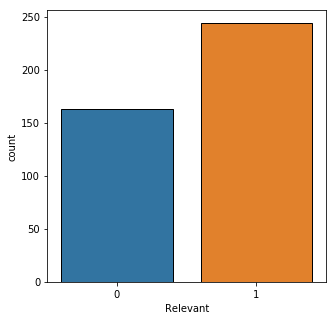

Cross_val_score: 0.824130315822389
AUC(ROC): 0.8773584905660378
Precision: 1.0
Recall: 0.7547169811320755
F1 score: 0.8602150537634409
[[29  0]
 [13 40]]
[[29  0]
 [13 40]]


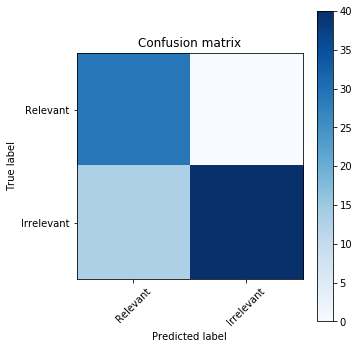

There are 326 relevant tweets.
 There are 163 irrelevant tweets.


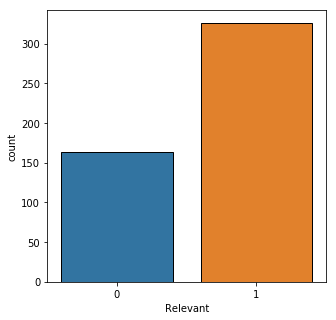

Cross_val_score: 0.7495153061224489
AUC(ROC): 0.875
Precision: 1.0
Recall: 0.75
F1 score: 0.8571428571428571
[[30  0]
 [17 51]]
[[30  0]
 [17 51]]


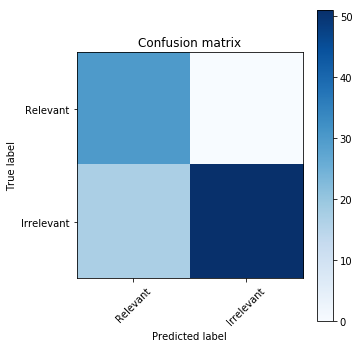

There are 407 relevant tweets.
 There are 163 irrelevant tweets.


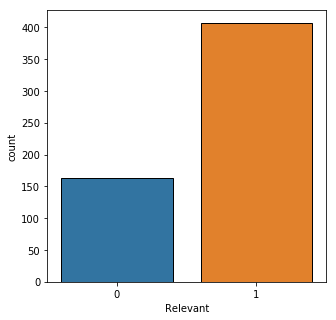

Cross_val_score: 0.7327586206896551
AUC(ROC): 0.8192771084337349
Precision: 1.0
Recall: 0.6385542168674698
F1 score: 0.7794117647058824
[[31  0]
 [30 53]]
[[31  0]
 [30 53]]


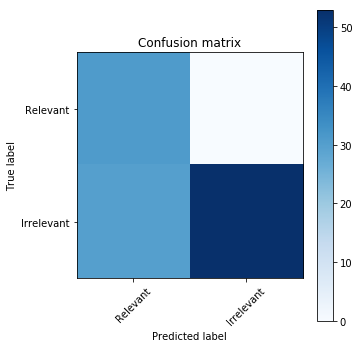

There are 489 relevant tweets.
 There are 163 irrelevant tweets.


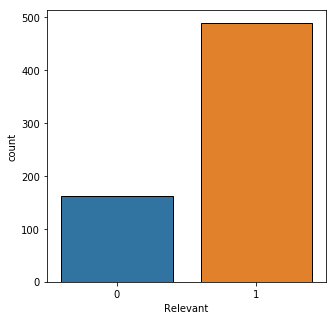

Cross_val_score: 0.7214352054195804
AUC(ROC): 0.5
Precision: 0.7557251908396947
Recall: 1.0
F1 score: 0.8608695652173913
[[ 0 32]
 [ 0 99]]
[[ 0 32]
 [ 0 99]]


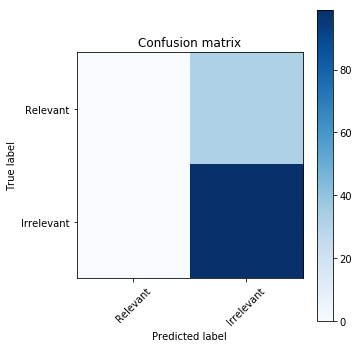

There are 570 relevant tweets.
 There are 163 irrelevant tweets.


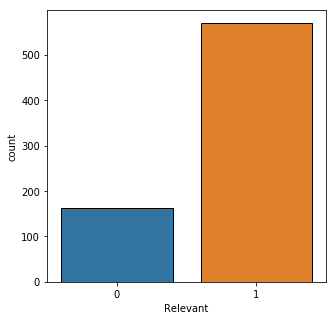

Cross_val_score: 0.7850140380106133
AUC(ROC): 0.5
Precision: 0.7482993197278912
Recall: 1.0
F1 score: 0.8560311284046693
[[  0  37]
 [  0 110]]
[[  0  37]
 [  0 110]]


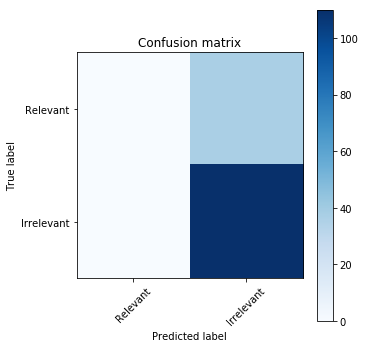

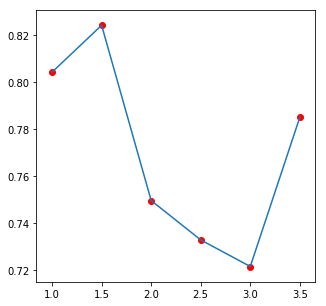

In [66]:
cross_val_scores=[]
for percentage in np.arange(1, 4, 0.5):
    X_train_vect, X_test_vect, y_train, y_test = undersample(tagged, percentage, vect)
    cross_val_s = classify(X_train_vect=X_train_vect,
        X_test_vect=X_test_vect,
        y_train =y_train,
        y_test=y_test,
        model=clf,
        vector=vect)
    cross_val_scores.append(cross_val_s)
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,4,0.5), cross_val_scores)
plt.scatter(np.arange(1,4,0.5), cross_val_scores, c='r')
plt.show()

### Experiment 2: Upsample the `Irrelevant` data

In [64]:
def oversample(data, vector):
    os = SMOTE(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(data.text, data.Relevant, test_size=0.2, random_state=100)
    X_train_vect = vector.fit_transform(X_train).todense()
    X_test_vect = vector.transform(X_test)
    os_X_train, os_y_train = os.fit_sample(X_train_vect, y_train)
    return os_X_train, X_test_vect, os_y_train, y_test

Cross_val_score: 0.8281613879832324
AUC(ROC): 0.8223684210526316
Precision: 1.0
Recall: 0.6447368421052632
F1 score: 0.7839999999999999
[[ 32   0]
 [ 81 147]]
[[ 32   0]
 [ 81 147]]


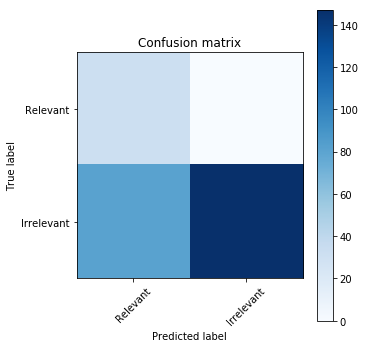

0.8281613879832324

In [65]:
X_train_vect, X_test_vect, y_train, y_test = oversample(tagged, vect)
classify(X_train_vect=X_train_vect,
        X_test_vect=X_test_vect,
        y_train =y_train,
        y_test=y_test,
        model=clf,
        vector=vect)